In [1]:
from datetime import datetime, timedelta
import json
from math import ceil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from models.qp.qpercent import QPercent
from util.batcher import Batcher
from util.stock_loader import Loader

In [2]:
!ls ../models/qp

__pycache__ data        qpercent.py


In [3]:
SD = 0.05 * (0.8 ** 4) # -4 ... 10 
print('SD:', SD)

SD: 0.020480000000000005


In [4]:
DATA = '../models/qp/data'
SYMBOLS = [
    'ABMD', 'ABNB', 'AMZN', 'ANET', 'ATVI', 'AXON', 'AYX', 'BILI', 'BYND', 
    'COUR','CPNG', 'DDOG', 'DOCU', 'DUOL', 'EDIT', 'ETSY', 'FSLY', 'FUV', 
    'GH', 'GMED', 'INTG', 'ISRG', 'JD', 'LULU', 'LUV', 'MDB', 'MELI', 
    'MNST', 'MTCH', 'NVCR', 'OKTA', 'PANW', 'PINS', 'PTON', 'QDEL', 
    'RDFN', 'RGEN', 'ROKU', 'SE', 'SHOP', 'TDOC', 'TEAM', 'TREX', 'TTD', 
    'TTWO', 'TWLO', 'TWTR', 'UPST', 'VEEV', 'ZEN', 'ZG', 'ZNGA']
INDICES = ['^GSPC', # S&P 500
           '^IXIC', # Nasdaq
           '^NYA']  # NY Stock Exchange (total)
len(SYMBOLS)

52

In [5]:
N_YEARS = 50
N_CUTS = 10
N_DAYS = int(round(365.25 * N_YEARS))
TODAY = datetime.now().date()
START = '1978-07-26' #str(TODAY - timedelta(N_DAYS))
START, TODAY

('1978-07-26', datetime.date(2021, 7, 30))

In [6]:
batcher = Batcher(SYMBOLS, INDICES)
batch = batcher.get_batch_from_weekday(TODAY.weekday())
batch

['TTWO', 'TWLO', 'TWTR', 'UPST', 'VEEV', 'ZEN', 'ZG', 'ZNGA', '^IXIC']

In [7]:
stock_loader = Loader(batch, START, verbose=True)
data = stock_loader.download()

[*********************100%***********************]  9 of 9 completed
Generating derived columns...
   ...TTWO
   ...TWLO
   ...TWTR
   ...UPST
   ...VEEV
   ...ZEN
   ...ZG
   ...ZNGA
   ...^IXIC


In [8]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock or x[0] == 'Date']]
    first_value = sub.Value[stock][sub.Value[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.index = range(sub.shape[0])
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [9]:
def str_to_tuple(s):
    s = s[1:-1]
    return tuple([float(x) for x in s.split(', ')])

str_to_tuple('(0.123, 0.456)')

(0.123, 0.456)

In [10]:
def read_best_params(stock):
    try:
        with open(f'{DATA}/{stock}_best.json', 'r') as f:
            params = json.load(f)
        for k in params:
            params[k]['q_params'] = {
                str_to_tuple(k): v 
                for k, v in params[k]['q_params'].items()}
        best_returns = {k: params[k]['best_return'] for k in params}
        print('Loaded current best.')
        return params, best_returns
    except FileNotFoundError:
        print('No saved data. Initialized as None')
        return None, None
    except:
        print(f'Unexpected error getting {stock} data. '
              'Initialized as None.')

In [11]:
def get_best_param_set(qp):
    best_param_set = qp.best_param_set
    for method in best_param_set:
        best_param_set[method]['best_return'] = qp.best_returns[method]
        # stringify tuple keys:
        best_param_set[method]['q_params'] = {
            str(k): v 
            for k, v in best_param_set[method]['q_params'].items()}
    return best_param_set

In [12]:
def save_best_param_set(best_param_set, stock):
    print(f'Saving {stock} params...')
    with open(f'{DATA}/{stock}_best.json', 'w') as f:
        json.dump(best_param_set, f)

In [13]:
if TODAY.weekday() == 0:
    !say update standard deviation




----------------------------------------------------------------------
                                 UPST
----------------------------------------------------------------------
No saved data. Initialized as None


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.6413144394199597
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 4 5
Beginning adjusted search...
Round: 206


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 1.6413144394199597
Refitting current best...
Fraction Invested: 1
Beginning random search...
New best: 1.6423133701069879
Invested: 0.5421627329168945
New best: 1.7133666853714713
Invested: 0.5676132541522909
New best: 1.6652573426062172
Invested: 0.6868884069523777
New best: 1.6688759735070988
Invested: 0.7762872499523545
Round: 5
Beginning adjusted search...
New best: 1.6688759735070988
Invested: 0.7762872499523545
New best: 1.6688759735

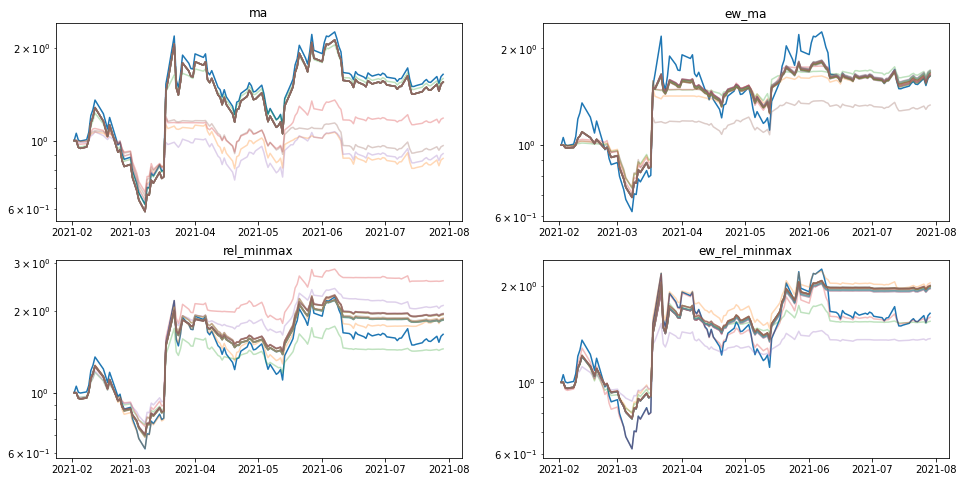

Saving UPST params...



----------------------------------------------------------------------
                                 VEEV
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 12.214836244695952
Refitting current best...
Current best ma returns: 12.71208129241214
Fraction Invested: 0.9996718774439958
Beginning random search...
Round: 5
Beginning adjusted search...
New best: 12.71242724900699
Invested: 0.9996718774439958
New best: 12.71235758571481
Invested: 0.9996718774439958
New best: 12.712319965293055
Invested: 0.9996718774439958
New best: 12.712022913849419
Invested: 0.9996718774439958
New best: 12.714230864187208
Invested: 0.9996718774439958
New best: 12.714027335205031
Invested: 0.9996718774439958
New best: 12.713904736604936
Invested: 0.9996718774439958
New best: 12.713919329851652
Invested: 0.9996718774439958
New best: 12.713886441055

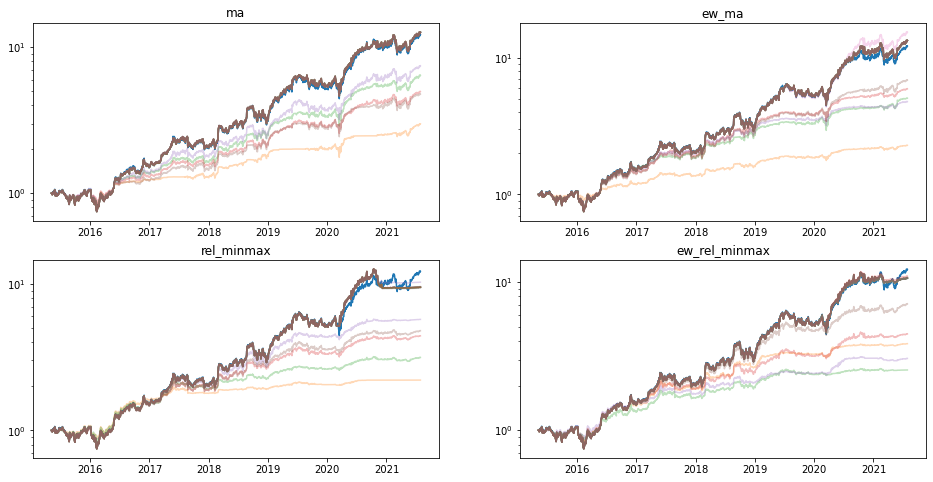

Saving VEEV params...



----------------------------------------------------------------------
                                 ZEN
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 7.617409034867124
Refitting current best...
Current best ma returns: 8.203366162747628
Fraction Invested: 0.997851727314616
Beginning random search...
Round: 5
Beginning adjusted search...
New best: 8.20123969878448
Invested: 0.997851727314616
New best: 8.20123969878448
Invested: 0.997851727314616
New best: 8.201427481453745
Invested: 0.997851727314616
New best: 8.204616019713804
Invested: 0.997851727314616
New best: 8.192260583260413
Invested: 0.997851727314616
New best: 8.191506642364795
Invested: 0.997851727314616
New best: 8.193441650673766
Invested: 0.997851727314616
New best: 8.187235497194177
Invested: 0.997851727314616
New best: 8.187065892065256
Invested: 0.9978

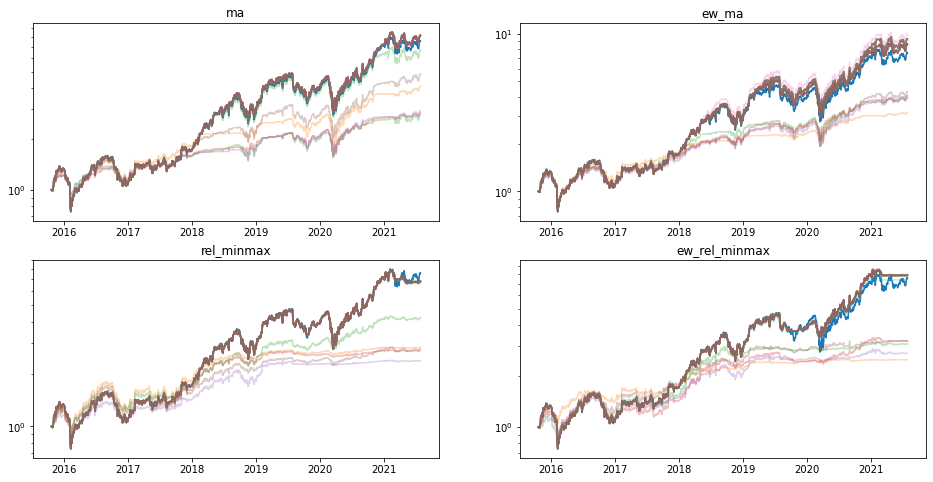

Saving ZEN params...



----------------------------------------------------------------------
                                 ZG
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 4.773372797280453
Refitting current best...
Current best ma returns: 5.552346341126286
Fraction Invested: 0.9974625809272385
Beginning random search...
Round: 5
Beginning adjusted search...
New best: 5.552346341126286
Invested: 0.9974625809272385
New best: 5.569345343234499
Invested: 0.9974625809272385
New best: 5.5711495088803495
Invested: 0.9974625809272385
New best: 5.570965109670258
Invested: 0.9974625809272385
New best: 5.596202889395713
Invested: 0.9974625809272385
New best: 5.596841445744378
Invested: 0.9974625809272385
New best: 5.581628286155442
Invested: 0.9974625809272385
New best: 5.559778794920542
Invested: 0.9974625809272385
New best: 5.540851597150684
Invest

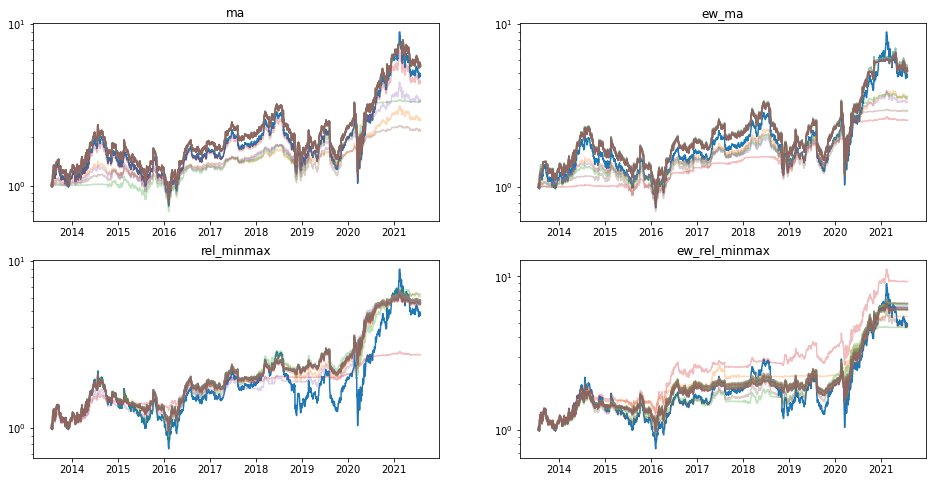

Saving ZG params...



----------------------------------------------------------------------
                                 ZNGA
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 2.5588972465522373
Refitting current best...
Current best ma returns: 3.261833273044478
Fraction Invested: 0.9998586501701161
Beginning random search...
Round: 5
Beginning adjusted search...
New best: 3.288548027556036
Invested: 0.9998586501701161
New best: 3.2891709901726993
Invested: 0.9998586501701161
New best: 3.2078630276454962
Invested: 0.9998586501701161
New best: 3.207962166809683
Invested: 0.9998586501701161
New best: 3.205378209678914
Invested: 0.9998586501701161
New best: 3.2090260980046743
Invested: 0.9998586501701161
New best: 3.2090602934939563
Invested: 0.9998586501701161
New best: 3.25725207311837
Invested: 0.9998586501701161
New best: 3.126563899809035
In

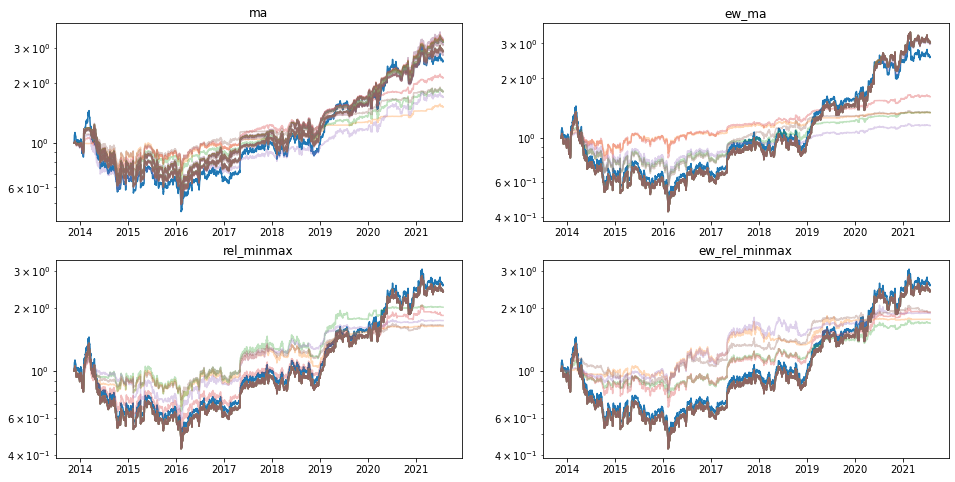

Saving ZNGA params...



----------------------------------------------------------------------
                                 ^IXIC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 35.4820162439976
Refitting current best...
Current best ma returns: 42.42561190192466
Fraction Invested: 0.9946862667634415
Beginning random search...
Round: 5
Beginning adjusted search...
New best: 42.41147958889642
Invested: 0.9946862667634415
New best: 42.41115519280676
Invested: 0.9946862667634415
New best: 42.411154096468955
Invested: 0.9946862667634415
New best: 42.42364917601512
Invested: 0.9946862667634415
New best: 42.42186293571263
Invested: 0.9946862667634415
New best: 42.421859411110574
Invested: 0.9946862667634415
New best: 42.39397112121056
Invested: 0.9946862667634415
New best: 42.37399113082179
Invested: 0.9946862667634415
New best: 42.37399113082179
In

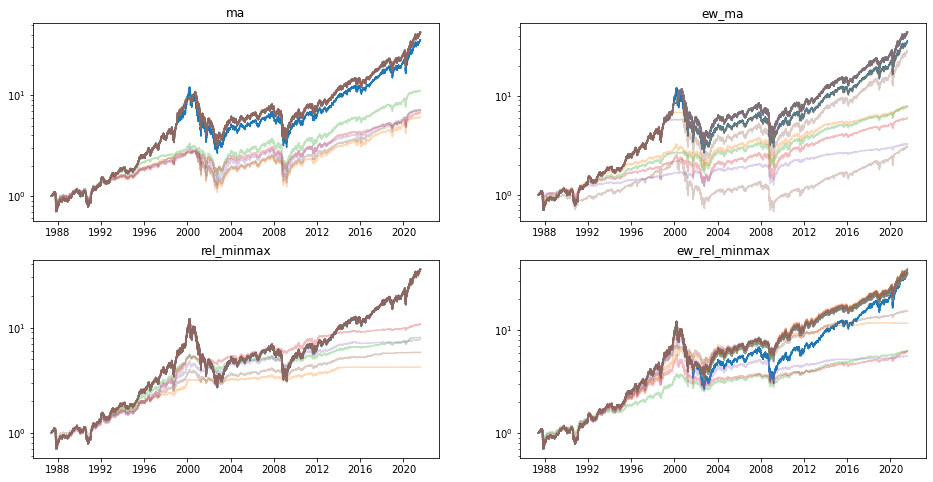

Saving ^IXIC params...


In [14]:
N_RAND = 5
N_ADJ = 20

for stock in batch:
    print('\n\n')
    print('-' * 70)
    print(' ' * 32, stock)
    print('-' * 70)
    best_params, best_returns = read_best_params(stock)
    stock_data = get_stock_data(stock, data)
    if stock == 'INTG':
        stock_data.fillna(method='ffill', inplace=True)
        stock_data.fillna(method='bfill', inplace=True)
    qp = QPercent(stock_data, 
                  N_CUTS, 
                  best_param_set=best_params, 
                  best_returns=best_returns, 
                  sd=SD)
    qp.run_sims(N_RAND, N_ADJ)
    best = get_best_param_set(qp)
    save_best_param_set(best, stock)

In [15]:
def get_summary(stocks):
    for stock in stocks:
        try:
            with open(f'{DATA}/{stock}_best.json', 'r') as f:
                best = json.load(f)
            best_method = None
            best_return = 0
            best_pct = None
            for key in best:
                ret = best[key]['best_return']
                if ret > best_return:
                    best_return = ret
                    best_method = key
                    best_pct = best[key]['pct']
            print(f'\n{stock}:\n  Best Return: {best_return} '
                  f'({best_method})\n  {100 * best_pct:.2f}% in')
        except FileNotFoundError:
            print('No data for', stock)
            continue
        except:
            print('Bad Data for', stock)
            continue

In [16]:
ALL = SYMBOLS + INDICES
#get_summary(ALL)
get_summary(batch)


TTWO:
  Best Return: 18.399345950841152 (ew_ma)
  99.85% in

TWLO:
  Best Return: 20.14479171801038 (ew_ma)
  99.78% in

TWTR:
  Best Return: 2.789352371905024 (ma)
  78.80% in

UPST:
  Best Return: 2.007033255117057 (ew_rel_minmax)
  51.62% in

VEEV:
  Best Return: 13.40494851439117 (ew_ma)
  99.89% in

ZEN:
  Best Return: 8.64104750313998 (ew_ma)
  99.39% in

ZG:
  Best Return: 6.077595710427488 (ew_rel_minmax)
  1.78% in

ZNGA:
  Best Return: 3.0322075306531127 (ew_ma)
  99.61% in

^IXIC:
  Best Return: 41.73339522088702 (ma)
  99.47% in


In [17]:
!say qp is dunzo

IXIC: Nasdaq